In [1]:
csv_path ="/home/mmeriles/dataset/full_dataset.csv"

In [2]:
import pandas as pd
import pickle
from db import DBHandler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time

dtypes = {
    'user.id_str': str,
    'id_str': str,
    'text': str,
    'retweeted_status.id_str': str ,
    'retweeted_status.user.id_str': str,
    'retweet_count': int,
    'quoted_status_id_str': str,
}
df = pd.read_csv(csv_path, dtype=dtypes)

# parse dates
datetime_cols = [c for c in df.columns if 'created_at' in c]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c])

# reemplazar nombre de columnas: . por __ para sintactic sugar de pandas.
df.rename(columns=lambda x: x.replace('.', '__'), inplace=True)

CPU times: user 49min 36s, sys: 9.51 s, total: 49min 46s
Wall time: 49min 46s


In [4]:
df.tail()

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str
15633828,2014-11-15 22:00:54,517662064,533741455916142593,3 Pasos que te ayudarán a concretar ventas en ...,NaN,NaN,NaT,0,NaN
15633829,2014-11-15 16:47:32,517662064,533662594352291840,RT @soymercadologo: ¿Cómo crear un concurso de...,533401510814560259,586259297,2014-11-14 23:30:04,1,NaN
15633830,2014-11-14 22:34:08,517662064,533387430976831488,3 Pasos que te ayudarán a concretar ventas en ...,NaN,NaN,NaT,0,NaN
15633831,2014-11-14 22:30:31,517662064,533386523807604736,"@muriel74 Por nada, ¡a lucirla ahora! :)",NaN,NaN,NaT,0,NaN
15633832,2014-11-14 22:25:14,517662064,533385193252737024,RT @Same09b: ¿Qué red social va a generarte me...,533384367112876033,729712033,2014-11-14 22:21:57,1,NaN


In [5]:
### READ FROM MONGODB CONNECTION


# h = DBHandler(port=27017)

# columns = ['created_at', 'id_str', 'retweet_count', 'retweeted_status__id_str', 'retweeted_status__created_at']
# separator = '__'
# project = ({f_name: '$' + f_name.replace(separator, '.') for f_name in columns})
# project.update({'retweeted_status': '$retweeted_status.id_str'})


# cursor = h.tweet_collection.aggregate([
#     {'$project': project}
# ])
# df = pd.DataFrame(list(cursor))

# # datatype conversion
# datetime_cols = [c for c in df.columns if 'created_at' in c]
# for c in datetime_cols:
#     df[c] = pd.to_datetime(df[c])

In [6]:
# usefull aliases
def df_only_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.notna()]

def df_not_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.isna()]

def df_commented(data_f):
    return data_f[data_f.quoted_status_id_str.notna()]

### Basic counts

In [7]:
%%time
quantity_of_users_on_ds = df.user__id_str.value_counts().count()
quantity_of_tweets_on_ds = df.id_str.value_counts().count()
print('Hay {} usuarios en el dataset.'.format(quantity_of_users_on_ds))
print('Hay {} tweets en el dataset.'.format(quantity_of_tweets_on_ds))

Hay 5338 usuarios en el dataset.
Hay 15633833 tweets en el dataset.
CPU times: user 17.1 s, sys: 524 ms, total: 17.6 s
Wall time: 17.6 s


# Recorte 1: tomar solo retweets que relacionan nuestros usuarios

Para algunos puntos desarrollados se tendrá en cuenta un recorte de dataset: Éste consiste en tomar, de todos los tweets recogidos, sólo aquellos que relacionan nuestros usuarios considerados para el estudio.

Se usará 'Global' para referirse a la totalidad de los tweets, y 'Recorte 1' para referirse a la selección mencionada.

(Problema 1: el campo retweeted_status devuelve el tweet original, no el tweet que se retweeteo. Es decir que si se trata de un RT de un RT, la relación retweeted_status ignora los intermedios y señala el tweet original.)

In [8]:
%%time
# estas tres cuentas dan cosas raras!!! (mirar la cantidad tmb, parecida a la cantidad de tweets-no-rt)
a = df.retweeted_status__id_str.isin(df.id_str).sum(), \
    df.retweeted_status__user__id_str.isin(df.user__id_str).sum()
print('RTs que tienen su tweet original en el dataset: {}\n'.format(a[0]) +
      'RTs que tienen al usuario original en el dataset: {}\n'.format(a[1]))

# (df.id_str tiene tweets originales de nuestros usuarios, por haber levantado timelines.)

RTs que tienen su tweet original en el dataset: 631579
RTs que tienen al usuario original en el dataset: 1414880

CPU times: user 6.48 s, sys: 244 ms, total: 6.73 s
Wall time: 6.68 s


In [9]:
### PROTOTYPE-FILTERING
def df_cut1(data_f):
    # tweets originales, o RT que su tweet original está en el dataset.
    return data_f[data_f.retweeted_status__id_str.isin(df.id_str) | data_f.retweeted_status__id_str.isna()] # df.id_str -> porque quiero todos mis usuarios!

### 1 Proporciones de RT sobre tweets totales

In [10]:
def print_dataset_proportions(data_f):
    cant_rt = df_only_rt(data_f).shape[0]
    cant_orig = df_not_rt(data_f).shape[0]
    cant_resp = df_commented(data_f).shape[0]
    total = data_f.shape[0]
    print('Cantidad de tweets originales: \t\t{}'.format(cant_orig))
    print('Cantidad de RT en el Dataset: \t\t{}'.format(cant_rt))
    print('Cantidad de respuestas a tweets: \t{}'.format(cant_resp))
    print('Total: \t\t\t\t\t{}\n'.format(total))
    cants = pd.DataFrame({'cantidades': [cant_orig, cant_rt , cant_resp]},
                         index=['originales', 'retweets', 'respuestas'])
    ax = (cants/1000).plot.bar(y='cantidades', figsize=(5, 5), legend=[])
    ax.set_title('Cantidades de tweets (miles)')

    print('Proporcion de RT sobre total: \t\t\t{}'.format(cant_rt / total))
    print('Proporcion de Tweets originales sobre total: \t{}'.format(cant_orig / total))
    print('Proporcion de Tweets respuestas a tweets sobre total: \t{}\n'.format(cant_resp / total))

    commented_and_retweeted = data_f[(data_f.quoted_status_id_str.notna()) & \
                                     (data_f.retweeted_status__id_str.notna())]\
                                    .shape[0]
    commented_and_not_rt = data_f[(data_f.quoted_status_id_str.notna()) & \
                                  (data_f.retweeted_status__id_str.isna())] \
                                 .shape[0]
    print('Cantidad tweets comentados y retweeteados: \t{}'.format(commented_and_retweeted))
    print('Cantidad tweets comentados y NO retweeteados: \t{}'.format(commented_and_not_rt))
    print('Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!')

### 1.0 Proporciones de RT sobre tweets totales (Global)

Cantidad de tweets originales: 		10865441
Cantidad de RT en el Dataset: 		4768392
Cantidad de respuestas a tweets: 	1055479
Total: 					15633833

Proporcion de RT sobre total: 			0.3050046652027049
Proporcion de Tweets originales sobre total: 	0.694995334797295
Proporcion de Tweets respuestas a tweets sobre total: 	0.06751249037903885



Cantidad tweets comentados y retweeteados: 	288118
Cantidad tweets comentados y NO retweeteados: 	767361
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 4.43 s, sys: 644 ms, total: 5.08 s
Wall time: 5.07 s


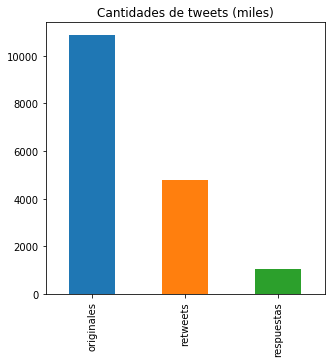

In [11]:
%%time
print_dataset_proportions(df)

### 1.1 Proporciones de RT sobre tweets totales (Recorte 1)

Cantidad de tweets originales: 		10865441
Cantidad de RT en el Dataset: 		631579
Cantidad de respuestas a tweets: 	818516
Total: 					11497020

Proporcion de RT sobre total: 			0.05493414815317361
Proporcion de Tweets originales sobre total: 	0.9450658518468263
Proporcion de Tweets respuestas a tweets sobre total: 	0.07119375281594709



Cantidad tweets comentados y retweeteados: 	51155
Cantidad tweets comentados y NO retweeteados: 	767361
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 9.56 s, sys: 644 ms, total: 10.2 s
Wall time: 10 s


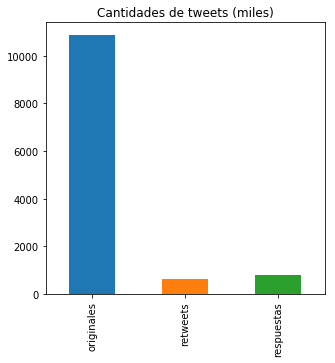

In [12]:
%%time
df_cutted = df_cut1(df)
print_dataset_proportions(df_cutted)

### 2 Promedio de conteos de retweets (usando retweet_count de la API de twitter)

In [13]:
def print_global_retweet_counts(data_f):
    avg_retweets_all = data_f.retweet_count.mean()
    print('Promedio de retweet counts (todo el dataset): \t\t{}'.format(avg_retweets_all))

    avg_retweets_nort = df_not_rt(data_f).retweet_count.mean()
    print('Promedio de retweet counts (solo tweets originales): \t{}'.format(avg_retweets_nort))

    # as retweets may point to the same tweet, we drop duplicates keeping the most updated one (oldest)
    avg_retweets_onlyrt =  df_only_rt(data_f).sort_values('created_at').drop_duplicates('retweeted_status__id_str', keep='last')\
        .retweet_count.mean()
    print('Promedio de retweet counts (solo retweets): \t\t{}'.format(avg_retweets_onlyrt))

### 2.0 Promedio de conteos de retweets (Global)

In [14]:
%%time
print_global_retweet_counts(df)

Promedio de retweet counts (todo el dataset): 		326.6253256638983


Promedio de retweet counts (solo tweets originales): 	34.08526096639796


Promedio de retweet counts (solo retweets): 		362.09089196852403
CPU times: user 7.04 s, sys: 596 ms, total: 7.64 s
Wall time: 7.57 s


### 2.1 Promedio de conteos de retweets (Recorte 1)

In [15]:
%%time
df_cutted = df_cut1(df)
print_global_retweet_counts(df_cutted)

Promedio de retweet counts (todo el dataset): 		81.11051524655954


Promedio de retweet counts (solo tweets originales): 	34.08526096639796


Promedio de retweet counts (solo retweets): 		246.0892303150458
CPU times: user 8.94 s, sys: 564 ms, total: 9.5 s
Wall time: 9.44 s


# Recorte 2: tomar sólo usuarios para los que se trajo el máximo de tweets por fetch_timeline

[Aquí](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) se puede ver que 3,200 es el máximo de tweets que se puede traer. Se filtra entonces los usuarios para los cuales se extrajo esa cantidad de tweets.

Se usará 'Recorte 2' para referirse a esa filtrado de tweets

In [16]:
def df_cut2(data_f, max_tweets=3200):
    _df_tweets_per_user = data_f.user__id_str.groupby(data_f.user__id_str).count()
    data_f['user_tweets_on_dataset'] = _df_tweets_per_user[data_f.user__id_str.values].values
    return data_f[data_f.user_tweets_on_dataset >= max_tweets]


### 3 Ventanas de tiempo recogidas

In [17]:
def print_time_windows(data_f):
    print('Tweet más temprano en el tiempo: \t{}'.format(data_f.created_at.min()))
    print('Tweet más tardío en el tiempo: \t\t{}'.format(data_f.created_at.max()))

    max_of_mins = data_f.created_at.groupby(data_f.user__id_str).min().max()
    print('Menor fecha de tweet disponible para todos los usuarios: {}'.format(max_of_mins))

### 3.0 Ventanas de tiempo recogidas (Global)

In [18]:
%%time
print_time_windows(df)

Tweet más temprano en el tiempo: 	2006-12-08 06:25:25


Tweet más tardío en el tiempo: 		2018-10-30 00:35:36


Menor fecha de tweet disponible para todos los usuarios: 2018-10-24 15:35:09
CPU times: user 688 ms, sys: 172 ms, total: 860 ms
Wall time: 871 ms


### 3.1 Ventanas de tiempo recogidas (Recorte 1)

In [19]:
%%time
df_cutted = df_cut1(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2006-12-08 06:25:25
Tweet más tardío en el tiempo: 		2018-10-30 00:33:24


Menor fecha de tweet disponible para todos los usuarios: 2018-10-25 05:37:56
CPU times: user 7.41 s, sys: 492 ms, total: 7.9 s
Wall time: 7.85 s


### 3.2 Ventanas de tiempo recogidas (Recorte 2)

In [20]:
%%time
df_cutted = df_cut2(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2007-04-11 23:52:28
Tweet más tardío en el tiempo: 		2018-10-30 00:35:36


Menor fecha de tweet disponible para todos los usuarios: 2018-10-24 15:35:09
CPU times: user 3.77 s, sys: 644 ms, total: 4.41 s
Wall time: 4.4 s


In [21]:
tweets_on_tweet_limit = df_cutted.shape[0]
users_on_tweet_limit = df_cutted.user__id_str.value_counts().count()
print('Tweets que tienen (igual) o más que el límite de tweets: {}'.format(tweets_on_tweet_limit))
print('Users que tienen (igual) o más que el límite de tweets: {}'.format(users_on_tweet_limit))

Tweets que tienen (igual) o más que el límite de tweets: 10035576
Users que tienen (igual) o más que el límite de tweets: 3116


### 4 Histograma de tweets y retweets por fecha

In [22]:
def plot_tweets_and_retweets_by_date(data_f):
    print('Valores a plotear: {}'.format(data_f.shape[0]))
    fig, ax = plt.subplots(figsize=(10,5))
    (data_f.created_at.groupby(data_f["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Todos los tweets')
    (data_f.created_at.groupby(df_only_rt(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo RT')
    (data_f.created_at.groupby(df_commented(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo con commentarios')
    ax.set_title('Histograma de tweets por fecha')
    ax.set_ylabel('cantidad (miles)')
    ax.set_xlabel('fecha')

### 4.0 Histograma de tweets y retweets por fecha (Global)

Valores a plotear: 15633833


CPU times: user 9.77 s, sys: 912 ms, total: 10.7 s
Wall time: 10.7 s


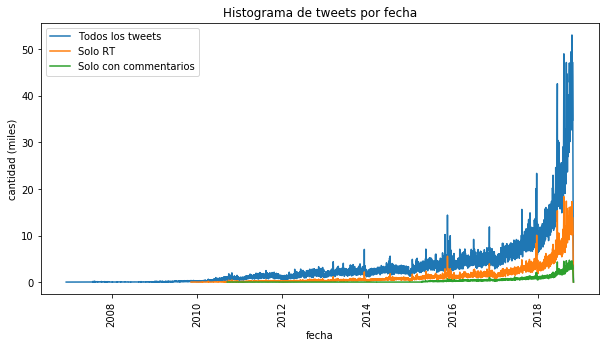

In [23]:
%%time
plot_tweets_and_retweets_by_date(df)

### 4.1 Histograma de tweets y retweets por fecha (Recorte 1)

Valores a plotear: 11497020


CPU times: user 12.7 s, sys: 1.14 s, total: 13.8 s
Wall time: 13.7 s


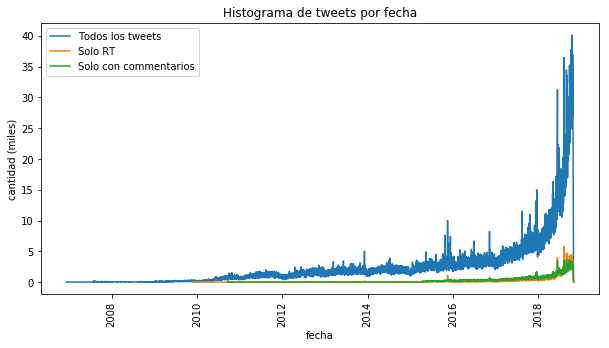

In [24]:
%%time
df_cutted = df_cut1(df)
plot_tweets_and_retweets_by_date(df_cutted)

### 4.2 Histograma de tweets y retweets por fecha (Recorte 2)

Valores a plotear: 10035576


CPU times: user 9.75 s, sys: 928 ms, total: 10.7 s
Wall time: 10.6 s


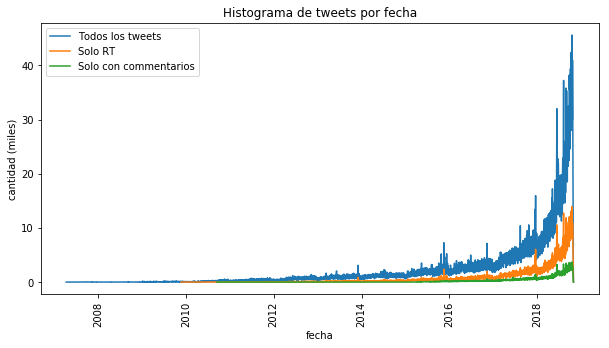

In [25]:
%%time
df_cutted = df_cut2(df)
plot_tweets_and_retweets_by_date(df_cutted)

### 5 Histograma de tweets y retweets por hora

Nota: se dejan afuera las primeras n horas por exceder los ordenes de magnitud para el ploteo

In [26]:
def plot_retweets_per_hour(data_f):
    data_f = data_f.copy()
    data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
    # agregar columna de primer aparicion en el dataset (created at oo si es RT, primer RT en el grupo)
    counts_per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
    
    def _find_first_n_outliers():
        head = counts_per_hour[0]
        for i in range(1, len(counts_per_hour)):
            if head < 2 * counts_per_hour[i]:
                break
            head = counts_per_hour[i]
        return i
    n_head_outliers = _find_first_n_outliers()
    first_n_hours_considered = 56

    print(counts_per_hour.head(n_head_outliers))
    print('Hay {} valores a plotear'.format(counts_per_hour.count()))
    counts_per_hour.head(first_n_hours_considered)[n_head_outliers:].plot(kind="line")

### 5.0 Histograma de tweets y retweets por hora (Global)

time_diff
0.0    2000236
1.0     690810
2.0     334497
Name: time_diff, dtype: int64
Hay 17582 valores a plotear


CPU times: user 5.97 s, sys: 828 ms, total: 6.79 s
Wall time: 6.77 s


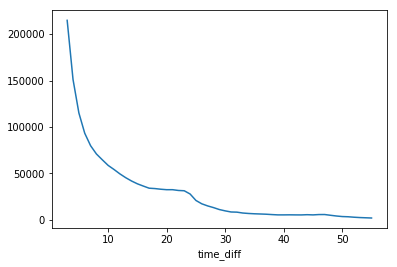

In [27]:
%%time
counts = plot_retweets_per_hour(df)

### 5.1 Histograma de tweets y retweets por hora (Recorte 1)

time_diff
0.0    227343
1.0     91972
Name: time_diff, dtype: int64
Hay 3354 valores a plotear
CPU times: user 9.49 s, sys: 696 ms, total: 10.2 s
Wall time: 9.99 s


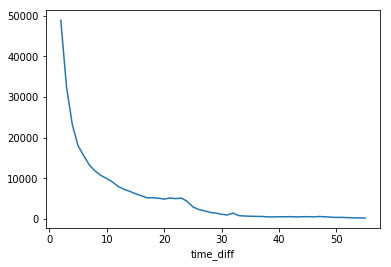

In [28]:
%%time
df_cutted = df_cut1(df)
counts = plot_retweets_per_hour(df_cutted)

### 5.2 Histograma de tweets y retweets por hora (Recorte 2)

time_diff
0.0    1165694
1.0     413919
2.0     200041
Name: time_diff, dtype: int64
Hay 11564 valores a plotear
CPU times: user 7.07 s, sys: 872 ms, total: 7.95 s


Wall time: 7.79 s


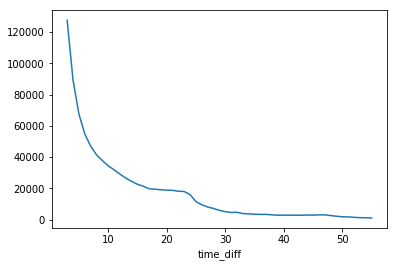

In [29]:
%%time
df_cutted = df_cut2(df)
counts = plot_retweets_per_hour(df_cutted)

### Retweets por hora de n tweets más retweeteados (en el dataset)

In [30]:
def annotate_df_with_rt_on_dataset(data_f):
    # dict-like series: key = retweeted_status__id_str  -> value = how many times was RTed in dataset
    _df_tweets_per_user = data_f.retweeted_status__id_str.groupby(data_f.retweeted_status__id_str).count()
    # add key for NaNs -> to be set to 0
    _df_tweets_per_user.loc['-1'] = 0
    # get data frame's retweeted_status__id_str field for completition.
    a = data_f.retweeted_status__id_str.fillna('-1').values
    # update Retweets
    data_f['rt_on_dataset'] = _df_tweets_per_user[a].values
    # update only original tweets # TODO

def get_top_retweeted(data_f, n=5):
    annotate_df_with_rt_on_dataset(data_f)
    top_retweeted = data_f.drop_duplicates('rt_on_dataset').nlargest(5, 'rt_on_dataset', keep='last')
    return top_retweeted.head(n)

def plot_tweets_per_hour(t_id, use_percentage=False):
    """For single tweet"""
    data_f = df[df.retweeted_status__id_str == str(t_id)]
    total = data_f.iloc[0].rt_on_dataset
    data_f['time_diff'] = data_f.created_at - data_f.retweeted_status__created_at

    # filter on max_hour ? TODO
    per_hour = (data_f.time_diff.groupby((data_f.time_diff / np.timedelta64(1, 'h')).round(0)).count())
    if use_percentage:
        per_hour = per_hour / total

    fig, axes = plt.subplots(ncols=2)
    per_hour.plot(kind="line", ax=axes[0],figsize=(15, 4))
    axes[0].set_title('Histograma de RT por hora a partir del tweet')
    axes[0].set_ylabel('cantidad')
    axes[0].set_xlabel('hora')
    per_hour.cumsum().plot(kind='line', ax=axes[1])
    axes[1].set_title('Histograma de RT por hora a partir del tweet acumulado')
    axes[1].set_ylabel('cantidad')
    axes[1].set_xlabel('hora')

RTs to be plotted for df: 235


/home/mmeriles/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RTs to be plotted for df: 195


RTs to be plotted for df: 161


RTs to be plotted for df: 143


RTs to be plotted for df: 142


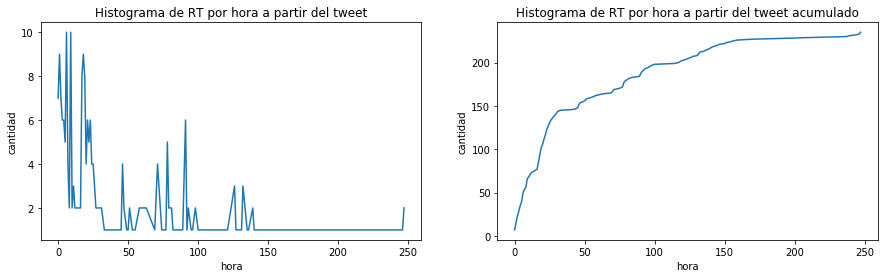

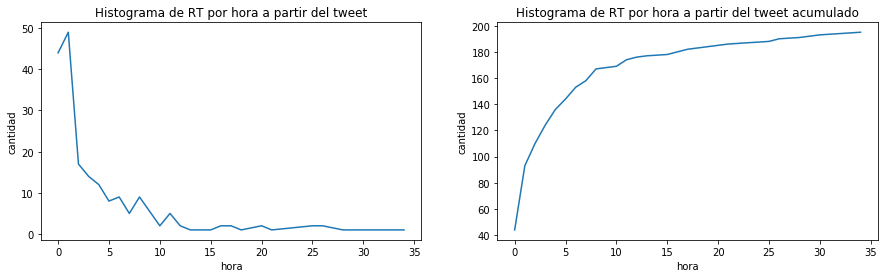

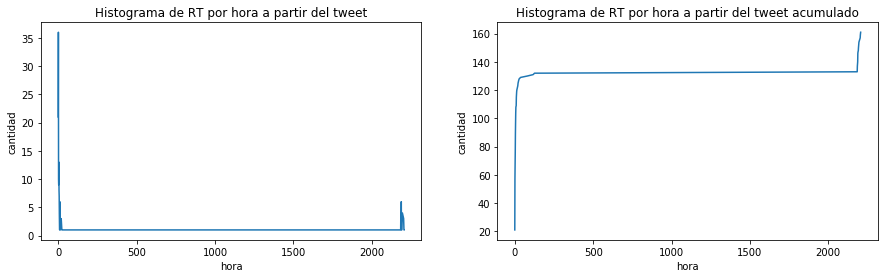

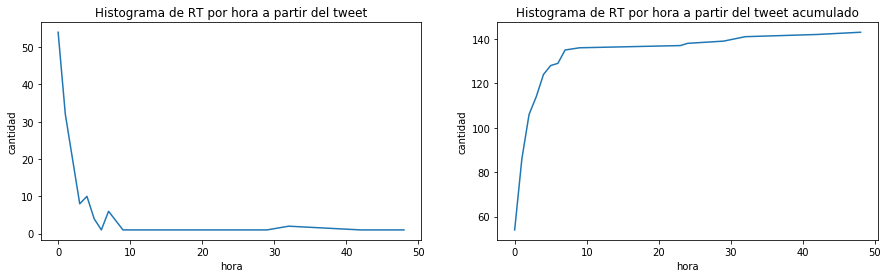

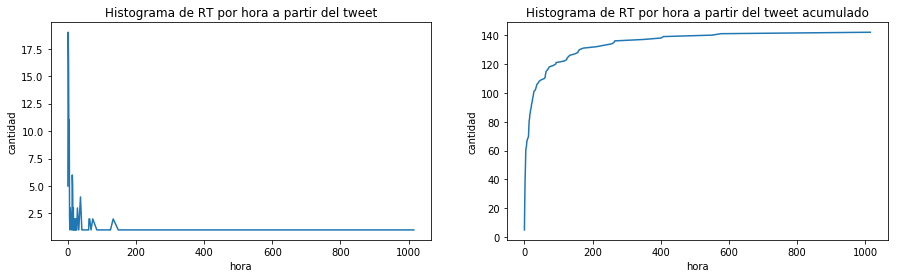

In [31]:
top_retweeted = get_top_retweeted(df)
for t_id in top_retweeted.retweeted_status__id_str:
    retweeted = df[df.retweeted_status__id_str == str(t_id)]
    print('RTs to be plotted for df: {}'.format(retweeted.shape[0]))
    plot_tweets_per_hour(t_id, use_percentage=False)

### Retweets por hora en general (porcentajes)

In [32]:
data_f = df.copy()
annotate_df_with_rt_on_dataset(data_f)
data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
df_only_rt(data_f)

# on progress


# total = data_f.iloc[0].rt_on_dataset
# data_f['time_diff'] = data_f.created_at - data_f.retweeted_status__created_at

# # filter on max_hour ? TODO
# per_hour = (data_f.time_diff.groupby((data_f.time_diff / np.timedelta64(1, 'h')).round(0)).count())
# if use_percentage:
#     per_hour = per_hour / total

# fig, axes = plt.subplots(ncols=2)
# per_hour.plot(kind="bar", ax=axes[0],figsize=(15, 4))
# per_hour.cumsum().plot(kind='bar', ax=axes[1])
# de[0:2].sum(), de[0:2]

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str,user_tweets_on_dataset,rt_on_dataset,time_diff
2,2018-10-22 11:35:12,143547590,1054335357507043335,RT @Cejota63: Entre Macri y la Iglesia de Berg...,1054182333174239233,88552641,2018-10-22 01:27:08,5,NaN,3205,1,10:08:04
3,2018-10-22 21:21:47,123916637,1054482974496956417,"RT @MGorban: Lo conocí tarde, hace apenas un p...",1054422842467594241,355805526,2018-10-22 17:22:50,2,NaN,3225,1,03:58:57
4,2018-10-22 21:21:17,123916637,1054482849242460162,"RT @hindelita: Murió Isidoro Gilbert, autor de...",1054465585487245313,49697215,2018-10-22 20:12:41,38,NaN,3225,15,01:08:36
5,2018-10-22 21:20:59,123916637,1054482774059634693,RT @IZuleta: Dolor por Isidoro... https://t.co...,1054466092968620032,155129878,2018-10-22 20:14:42,9,NaN,3225,4,01:06:17
6,2018-10-22 21:20:10,123916637,1054482570371588101,RT @JorBusico: Me entero que se fue de gira Is...,1054449499328921600,135218756,2018-10-22 19:08:46,3,NaN,3225,2,02:11:24
7,2018-10-22 21:20:08,123916637,1054482559311196161,RT @CarasyCaretasTw: Hoy a la tarde falleció I...,1054469781556998146,1119961578,2018-10-22 20:29:21,15,NaN,3225,3,00:50:47
8,2018-10-22 17:26:46,123916637,1054423834017837056,RT @DiarioPulse: VIDEO | Habló Nicolás “Nicky”...,1054399323335786497,545402534,2018-10-22 15:49:23,347,NaN,3225,13,01:37:23
10,2018-10-22 14:36:33,123916637,1054380994432774144,RT @AleRuaTwit: El juez Bonadio pide que se in...,1054374634974523394,1247076385,2018-10-22 14:11:16,103,NaN,3225,10,00:25:17
17,2018-10-22 23:28:21,382635219,1054514826452582400,RT @karin_arcuschin: @rinconet @ditulliojuli M...,1054478381587316739,1857719958,2018-10-22 21:03:32,2,NaN,3217,1,02:24:49
20,2018-10-22 18:51:59,382635219,1054445278806372352,RT @NagusInfo: Cuando @Sabbatella pasó por @La...,1054443427369308161,140963498,2018-10-22 18:44:38,14,NaN,3217,4,00:07:21
